# Image Classification - Search Space and Hyperparameter Optimization (HPO)

한 줄의 코드만으로 쉽게 이미지 분류를 수행할 수 있지만, 보다 높은 성능을 위해 하이퍼파라메터의 검색 공간(search space)을 찾고 검색 공간 내에서 최적의 하이퍼파라메터를 자동으로 찾을 수 있습니다. 본 핸즈온에서 이를 수행하겠습니다.

AutoGluon은 아키텍처 검색을 포함한 적절한 검색 공간을 찾는 전략과 하이퍼파라메터 최적화(HPO)를 동시에 지원합니다.

- `autogluon.core.searcher`: 최적 하이퍼파라메터 검색 공간 탐색
- `autogluon.core.scheduler`: 개별 훈련 작업이 예약되는 방식을 조정하며, FIFO, Hyperband, RL(Reinforcement Learning) 스케줄링을 지원합니다.

Searcher와 Scheduler에 대한 좀 더 자세한 예제는 `5.hpo` 폴더의 예제들을 참조하세요.
- [Searcher 예제](../5.hpo/01_search_space.ipynb)
- [Scheduler에 예제](../5.hpo/02_scheduler.ipynb)

In [1]:
import autogluon.core as ag
from autogluon.vision import ImagePredictor

<br>

## 1. Data Preparation and Training

In [2]:
train_data, _, test_data = ImagePredictor.Dataset.from_folders('https://autogluon.s3.amazonaws.com/datasets/shopee-iet.zip')

data/
├── test/
└── train/


### Specify which Networks to Try

AutoGluon-Vision은 GluonCV와 연계하여 사전 훈련된 수많은 vision 모델들을 제공하고 있습니다. 
아래 코드는 `autogluon.core.space.Categorical`로 검색 공간을 정의하는 예시를 보여줍니다.

In [3]:
# you may choose more than 70+ available model in the model zoo provided by GluonCV:
model_list = ImagePredictor.list_models()
model_list

('resnet18_v1',
 'resnet34_v1',
 'resnet50_v1',
 'resnet101_v1',
 'resnet152_v1',
 'resnet18_v2',
 'resnet34_v2',
 'resnet50_v2',
 'resnet101_v2',
 'resnet152_v2',
 'resnest14',
 'resnest26',
 'resnest50',
 'resnest101',
 'resnest200',
 'resnest269',
 'se_resnet18_v1',
 'se_resnet34_v1',
 'se_resnet50_v1',
 'se_resnet101_v1',
 'se_resnet152_v1',
 'se_resnet18_v2',
 'se_resnet34_v2',
 'se_resnet50_v2',
 'se_resnet101_v2',
 'se_resnet152_v2',
 'vgg11',
 'vgg13',
 'vgg16',
 'vgg19',
 'vgg11_bn',
 'vgg13_bn',
 'vgg16_bn',
 'vgg19_bn',
 'alexnet',
 'densenet121',
 'densenet161',
 'densenet169',
 'densenet201',
 'squeezenet1.0',
 'squeezenet1.1',
 'googlenet',
 'inceptionv3',
 'xception',
 'xception71',
 'mobilenet1.0',
 'mobilenet0.75',
 'mobilenet0.5',
 'mobilenet0.25',
 'mobilenetv2_1.0',
 'mobilenetv2_0.75',
 'mobilenetv2_0.5',
 'mobilenetv2_0.25',
 'mobilenetv3_large',
 'mobilenetv3_small',
 'cifar_resnet20_v1',
 'cifar_resnet56_v1',
 'cifar_resnet110_v1',
 'cifar_resnet20_v2',
 'cifar_

In [4]:
model = ag.Categorical('resnet18_v1b', 'mobilenetv3_small')
lr = ag.Categorical(1e-2, 1e-3)
batch_size = 8


### Bayesian Optimization and Hyperband Early Stopping
 
Early Stopping은 훈련 초기에 모델의 성능이 이미 나빠 보이는 경우 훈련을 조기에 종료하여 컴퓨팅 리소스를 확보할 수 있습니다.<br>
AutoGluon은 현재 순차 실행(serial order) 그리고 early stopping를 통한 스케줄링을 지원하며, 아래 코드는 early stopping 스케줄러 `autogluon.core.scheduler.HyperbandScheduler`를 사용하는 예시입니다.

In [5]:
hyperparameters = {'model': model, 
                   'batch_size': batch_size, 
                   'lr': lr, 
                   'epochs': 2,
                   'search_strategy': 'bayesopt_hyperband'
                  }

INFO:gluoncv.auto.tasks.image_classification:Randomly split train_data into train[716]/validation[84] splits.
INFO:gluoncv.auto.tasks.image_classification:Starting HPO experiments
INFO:autogluon.core.scheduler.fifo:Starting Hyperparameter Tuning ... (time_out=120s)


scheduler: FIFOScheduler(
DistributedResourceManager{
(Remote: Remote REMOTE_ID: 0, 
	<Remote: 'inproc://172.16.44.56/31175/1' processes=1 threads=8, memory=64.38 GB>, Resource: NodeResourceManager(8 CPUs, 1 GPUs))
})



  0%|          | 0/2 [00:00<?, ?it/s]

INFO:ImageClassificationEstimator:modified configs(<old> != <new>): {
INFO:ImageClassificationEstimator:root.img_cls.model   resnet50_v1 != resnet18_v1b
INFO:ImageClassificationEstimator:root.train.epochs    10 != 2
INFO:ImageClassificationEstimator:root.train.rec_train ~/.mxnet/datasets/imagenet/rec/train.rec != auto
INFO:ImageClassificationEstimator:root.train.rec_val   ~/.mxnet/datasets/imagenet/rec/val.rec != auto
INFO:ImageClassificationEstimator:root.train.num_workers 4 != 8
INFO:ImageClassificationEstimator:root.train.data_dir  ~/.mxnet/datasets/imagenet != auto
INFO:ImageClassificationEstimator:root.train.rec_train_idx ~/.mxnet/datasets/imagenet/rec/train.idx != auto
INFO:ImageClassificationEstimator:root.train.rec_val_idx ~/.mxnet/datasets/imagenet/rec/val.idx != auto
INFO:ImageClassificationEstimator:root.train.batch_size 128 != 8
INFO:ImageClassificationEstimator:root.train.lr        0.1 != 0.01
INFO:ImageClassificationEstimator:root.train.num_training_samples 1281167 != -1


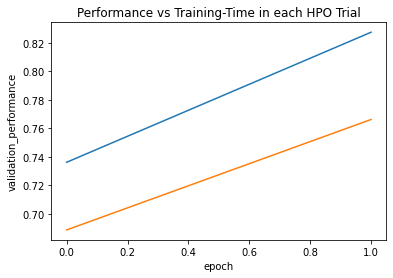

INFO:gluoncv.auto.tasks.image_classification:Finished, total runtime is 56.69 s
INFO:gluoncv.auto.tasks.image_classification:{ 'best_config': { 'estimator': <class 'gluoncv.auto.estimators.image_classification.image_classification.ImageClassificationEstimator'>,
                   'gpus': [0],
                   'img_cls': { 'batch_norm': False,
                                'last_gamma': False,
                                'model': 'resnet18_v1b',
                                'use_gn': False,
                                'use_pretrained': True,
                                'use_se': False},
                   'train': { 'batch_size': 8,
                              'crop_ratio': 0.875,
                              'data_dir': 'auto',
                              'dtype': 'float32',
                              'epochs': 2,
                              'hard_weight': 0.5,
                              'input_size': 224,
                              'label_smoothing'

Top-1 val acc: 0.766
CPU times: user 50.6 s, sys: 12.5 s, total: 1min 3s
Wall time: 1min 1s


In [6]:
%%time
hyperparameters = {'model': model, 'batch_size': batch_size, 'lr': lr, 'epochs': 2}
predictor = ImagePredictor()
predictor.fit(train_data, time_limit=60*2, hyperparameters=hyperparameters,
              hyperparameter_tune_kwargs={'num_trials': 2})
print('Top-1 val acc: %.3f' % predictor.fit_summary()['valid_acc'])

In [7]:
top1, top5 = predictor.evaluate(test_data)
print('Test acc on hold-out data:', top1)

Test acc on hold-out data: 0.8


<br>

## 2. EfficientNet’s Neural Architecture Search(NAS)
스케줄링 외에 최적의 아키텍처를 찾는 과정도 쉽게 수행이 가능하며, 아래 코드 셀의 예제를 확인해 주세요.
(https://auto.gluon.ai/model_zoo/index.html 에서도 확인 가능합니다.)

In [8]:
import math
import autogluon.core as ag
from autogluon.mxnet.optimizer import SGD
from autogluon.extra.model_zoo import EfficientNet
from autogluon.vision import ImagePredictor

@ag.obj(
    width_coefficient=ag.Categorical(1.1, 1.2),
    depth_coefficient=ag.Categorical(1.1, 1.2),
)
class EfficientNetB1(EfficientNet):
    def __init__(self, width_coefficient, depth_coefficient):
        input_factor = math.sqrt(2.0 / (width_coefficient ** 2) / depth_coefficient)
        input_size = math.ceil((224 * input_factor) / 32) * 32
        super().__init__(width_coefficient=width_coefficient,
                         depth_coefficient=depth_coefficient,
                         input_size=input_size)

In [9]:
hyperparameters = {
   'net':EfficientNetB1(),
   'optimizer': SGD(learning_rate=1e-1, momentum=0.9, wd=1e-4),
   'batch_size': 16
}

In [10]:
predictor = ImagePredictor()
predictor.fit(train_data, time_limit=60*2, hyperparameters=hyperparameters)
print(predictor.fit_summary())

INFO:gluoncv.auto.tasks.image_classification:Randomly split train_data into train[725]/validation[75] splits.
INFO:gluoncv.auto.tasks.image_classification:Starting fit without HPO
INFO:ImageClassificationEstimator:modified configs(<old> != <new>): {
INFO:ImageClassificationEstimator:root.img_cls.model   resnet50_v1 != resnet50_v1b
INFO:ImageClassificationEstimator:root.train.epochs    10 != 15
INFO:ImageClassificationEstimator:root.train.rec_train ~/.mxnet/datasets/imagenet/rec/train.rec != auto
INFO:ImageClassificationEstimator:root.train.rec_val   ~/.mxnet/datasets/imagenet/rec/val.rec != auto
INFO:ImageClassificationEstimator:root.train.num_workers 4 != 8
INFO:ImageClassificationEstimator:root.train.data_dir  ~/.mxnet/datasets/imagenet != auto
INFO:ImageClassificationEstimator:root.train.rec_train_idx ~/.mxnet/datasets/imagenet/rec/train.idx != auto
INFO:ImageClassificationEstimator:root.train.rec_val_idx ~/.mxnet/datasets/imagenet/rec/val.idx != auto
INFO:ImageClassificationEstimat

INFO:ImageClassificationEstimator:[Epoch 10] speed: 216 samples/sec	time cost: 5.535682
INFO:ImageClassificationEstimator:[Epoch 10] validation: top1=0.976250 top5=1.000000
INFO:ImageClassificationEstimator:[Epoch 10] Current best top-1: 0.976250 vs previous 0.972500, saved to /home/ec2-user/SageMaker/autogluon-hol/3.cv/2a02043b/.trial_0/best_checkpoint.pkl
INFO:ImageClassificationEstimator:Pickled to /home/ec2-user/SageMaker/autogluon-hol/3.cv/2a02043b/.trial_0/best_checkpoint.pkl
INFO:ImageClassificationEstimator:Epoch[11] Batch [49]	Speed: 223.233495 samples/sec	accuracy=0.871250	lr=0.010000
INFO:ImageClassificationEstimator:[Epoch 11] training: accuracy=0.871250
INFO:ImageClassificationEstimator:[Epoch 11] speed: 218 samples/sec	time cost: 5.481331
INFO:ImageClassificationEstimator:[Epoch 11] validation: top1=0.975000 top5=1.000000
INFO:ImageClassificationEstimator:Epoch[12] Batch [49]	Speed: 214.534640 samples/sec	accuracy=0.872500	lr=0.010000
INFO:ImageClassificationEstimator:[Ep

{'train_acc': 0.8625, 'valid_acc': 0.98625, 'total_time': 95.68421530723572, 'best_config': {'model': 'resnet50_v1b', 'lr': 0.01, 'num_trials': 1, 'epochs': 15, 'batch_size': 16, 'nthreads_per_trial': 128, 'ngpus_per_trial': 8, 'time_limits': 120, 'search_strategy': 'random', 'dist_ip_addrs': None, 'log_dir': '/home/ec2-user/SageMaker/autogluon-hol/3.cv/2a02043b', 'custom_net': EfficientNetB1(
  (features): HybridSequential(
    (0): SamePadding(0, 1, 0, 1)
    (1): Conv2D(None -> 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (2): BatchNorm(axis=1, eps=0.001, momentum=0.99, fix_gamma=False, use_global_stats=False, in_channels=32)
    (3): Swish (beta=1.0)
  )
  (_blocks): HybridSequential(
    (0): MBConvBlock(
      (depth_conv): HybridSequential(
        (0): SamePadding(1, 1, 1, 1)
        (1): Conv2D(1 -> 32, kernel_size=(3, 3), stride=(1, 1), groups=32, bias=False)
        (2): BatchNorm(axis=1, eps=0.001, momentum=0.99, fix_gamma=False, use_global_stats=False, in_channel

In [11]:
top1, top5 = predictor.evaluate(test_data)
print('Test acc on hold-out data:', top1)

Test acc on hold-out data: 0.9375
